In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('glass.data',header=None)
df.columns = ['ID','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Class']
df = df.iloc[:,1:]
print(df.head())

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [10]:
print(df.describe())

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


###### Class 1: building windows (float processed)
###### Class 2: building windows (non-float processed)
###### Class 3: vehicle windows (float processed)
###### Class 4: vehicle windows (non-float processed) (0 samples in this data)
###### Class 5: containers
###### Class 6: tableware
###### Class 7: headlamps

In [8]:
class_info = df.groupby('Class').count().iloc[:,0]
print(class_info)

Class
1    70
2    76
3    17
5    13
6     9
7    29
Name: RI, dtype: int64

(array([70., 76.,  0., 17.,  0.,  0., 13.,  0.,  9., 29.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

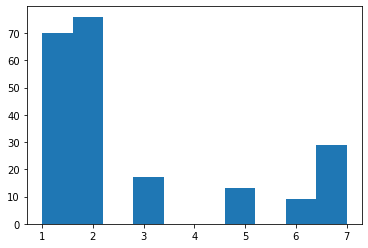

In [31]:
plt.hist(df['Class'])
plt.show()

#### The dataset can be divided into
Window Glass: 163 samples

non-window glass: 51 samples
#### Or
Float Glass: 87 samples

non-float glass: 76 samples
#### which is more balanced

In [34]:
for i in class_info.index:
    c = class_info[i]
    print(f'Class {i}, Count:{c}, Percentage:{round(c*100/214,3)}%')

Class 1, Count:70, Percentage:32.71%
Class 2, Count:76, Percentage:35.514%
Class 3, Count:17, Percentage:7.944%
Class 5, Count:13, Percentage:6.075%
Class 6, Count:9, Percentage:4.206%
Class 7, Count:29, Percentage:13.551%


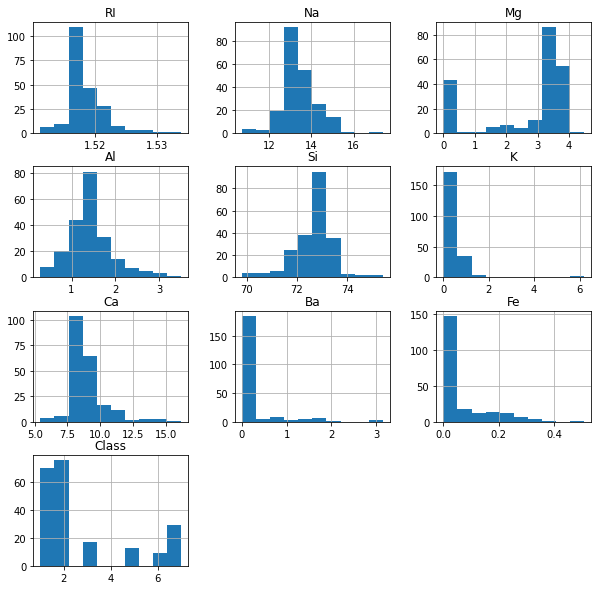

In [42]:
df.hist(figsize=(10,10))
plt.show()

In [838]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.33,stratify=Y,random_state=1)

In [839]:
ss=StandardScaler()
le=LabelEncoder()
X = ss.fit_transform(X_train)
y = le.fit_transform(y_train)
X_test = ss.transform(X_test)
y_test = le.transform(y_test)
print("X,y shape:",X.shape,y.shape)

(143, 9) (143,)


In [840]:
def evaluate(X,y,estimator):
    cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=10)
    score = cross_val_score(estimator,X,y,scoring='accuracy',cv=cv)
    return score

### Baseline: 35% (Predicting class 2 for every sample)

### We'll now evaluate several models 

In [841]:
lm = LogisticRegression(penalty='l2',solver='newton-cg')
svm = SVC(gamma='auto')
knn = KNeighborsClassifier()
dTree = DecisionTreeClassifier(max_depth=100)
weights = {0:1.0,1:1.0,2:2.0,3:2.0,4:2.0,5:2.0}
rf = RandomForestClassifier(n_estimators=1000,class_weight=weights)

models = {'Logistic Regression':lm,'SVM':svm,'KNN':knn,'Decision Tree':dTree,'Random Forest': rf}

results = []
print("Cross val average accuracy(without oversampling or hyperparameter tuning)")
for k,v in models.items():
    result = evaluate(X,y,v)
    results.append(result)
    print(f'{k}: {round(np.mean(result),3)}')

Logistic Regression: 0.606
SVM: 0.651
KNN: 0.592
Decision Tree: 0.668
Random Forest: 0.752


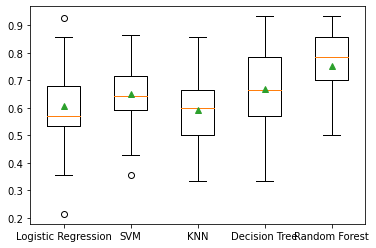

In [842]:
plt.boxplot(results,labels=models.keys(),showmeans=True)
plt.show()

#### Using SMOTE(Synthetic Minority Oversampling technique) Oversampling
#### Let's take a look again on what the class ditribution looks like

<BarContainer object of 6 artists>

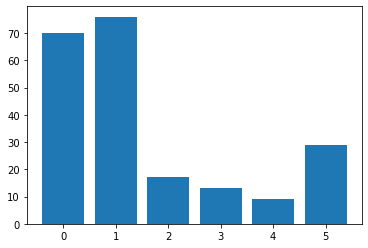

In [843]:
plt.bar(np.unique(y),class_info)
plt.show()

#### Using SMOTE

In [844]:
X,y = SMOTE(sampling_strategy = {0:200, 1:200, 2:200, 3:200, 4:200, 5:200}).fit_resample(X,y)

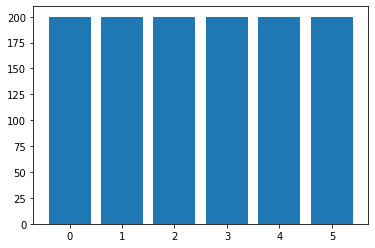

In [845]:
names,counts = np.unique(y,return_counts=True)
plt.bar(names,counts)
plt.show()

#### Re-evaluate model on oversampled data

In [846]:
lm = LogisticRegression(penalty='l2',solver='newton-cg')
svm = SVC(gamma='auto')
knn = KNeighborsClassifier()
dTree = DecisionTreeClassifier(max_depth=100)
rf = RandomForestClassifier(n_estimators=1000,class_weight='balanced')

models = {'Logistic Regression':lm,'SVM':svm,'KNN':knn,'Decision Tree':dTree,'Random Forest': rf}

results = []
print("Cross val average accuracy on oversampled data(without hyperparameter tuning)")
for k,v in models.items():
    result = evaluate(X,y,v)
    results.append(result)
    print(f'{k}: {round(np.mean(result),3)}')

Logistic Regression: 0.882
SVM: 0.927
KNN: 0.956
Decision Tree: 0.944
Random Forest: 0.98


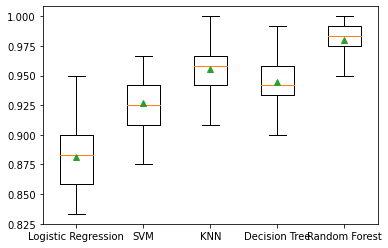

In [847]:
plt.boxplot(results,labels=models.keys(),showmeans=True)
plt.show()

### Hyperparameter Tuning

In [ ]:
print("Hyperparameter Tuning")

In [848]:
params = {'penalty':('l1', 'l2'),'tol':[1e-4,1e-3],'C':[1.0,3.0,5.0],
             'class_weight':('balanced',None),'solver':('newton-cg', 'lbfgs', 'liblinear'),'multi_class':('auto', 'ovr', 'multinomial')}
clf = GridSearchCV(LogisticRegression(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
lm_best = clf.best_estimator_
print("Logistic Regresion:")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Best Result: 0.8991666666666667
Best Param: {'C': 5.0, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}


In [849]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],'weights':('uniform','distance'),
             'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
         'p':[1,2,3,4]}
clf = GridSearchCV(KNeighborsClassifier(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
knn_best = clf.best_estimator_
print("KNN")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Best Result: 0.9816666666666667
Best Param: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}


In [850]:
params = {'C':[1.0,1.5,2.0,2.5,3.0,4.0,5.0],'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
             'gamma':('scale','auto'),'decision_function_shape':('ovo', 'ovr')}
clf = GridSearchCV(SVC(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
svm_best = clf.best_estimator_
print("SVM")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Best Result: 0.9533333333333334
Best Param: {'C': 5.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}


In [851]:
params = {'criterion':('gini', 'entropy'),'splitter':('best', 'random'),'max_depth':[10,50,100,500,1000],
          'min_samples_split':[1,2,5,10],'min_samples_leaf':[1,2,3,5],'max_features':('auto','sqrt','log2',None)}
clf = GridSearchCV(DecisionTreeClassifier(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
dTree_best = clf.best_estimator_
print("Decision Tree")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Best Result: 0.9483333333333335
Best Param: {'criterion': 'entropy', 'max_depth': 1000, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [852]:
params = {'n_estimators':[1,10,100,1000],'max_depth':[1,10,100,1000],
          'min_samples_split':[1,2],'min_samples_leaf':[1,2],
         'class_weight':('balanced', 'balanced_subsample',None)}
clf = GridSearchCV(RandomForestClassifier(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
rf_best = clf.best_estimator_
print("Random Forest")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Best Result: 0.9808333333333333
Best Param: {'class_weight': None, 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [853]:
models = {'Logistic Regression':lm_best,'SVM':svm_best,'KNN':knn_best,'Decision Tree':dTree_best,'Random Forest': rf_best}

results = []
print("Cross val average accuracy on oversampled data and hyperparameter tuned model")
for k,v in models.items():
    result = evaluate(X,y,v)
    results.append(result)
    print(f'{k}: {round(np.mean(result),3)}')

Logistic Regression: 0.895
SVM: 0.949
KNN: 0.982
Decision Tree: 0.95
Random Forest: 0.978


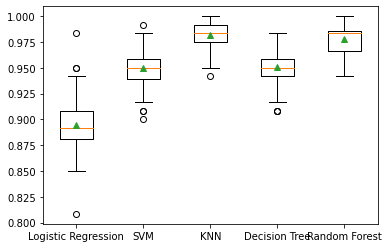

In [854]:
plt.boxplot(results,labels=models.keys(),showmeans=True)
plt.show()

In [855]:
models = {'Logistic Regression':lm_best,'SVM':svm_best,'KNN':knn_best,'Decision Tree':dTree_best,'Random Forest': rf_best}
results = []
print("Test set accuracy")
for k,v in models.items():
    v.fit(X,y)
    y_pred = v.predict(X_test)
    results.append(accuracy_score(y_test,y_pred))
    print(f'{k}: {round(accuracy_score(y_test,y_pred),3)}')

Logistic Regression: 0.69
SVM: 0.775
KNN: 0.746
Decision Tree: 0.761
Random Forest: 0.859


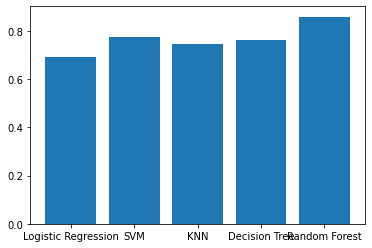

In [856]:
plt.bar(models.keys(),results)
plt.show()

### Neural Networks

In [ ]:
print("Neural Network Training")

In [857]:
Y=y
YY = np.zeros((len(Y) , 1))
YY[:,0] = Y
enc = OneHotEncoder(sparse = False , handle_unknown='error')
enc.fit(YY)
Y_transformed = enc.transform(YY)

In [892]:
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import Sequential
def Glass_Deep_Model(dropout_rate = 0.5 , activation='relu' , optimizer='adam',loss='binary_crossentropy'):
    # create model
    model = Sequential()
    model.add(Dense(9, input_dim=9, activation=activation))
    #model.add(Dense(1024, activation=activation))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(512,  activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256,  activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6,  activation="softmax"))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [893]:
from keras.wrappers.scikit_learn import KerasClassifier
Final_Model = KerasClassifier(build_fn=Glass_Deep_Model, verbose=0)

In [894]:
history = Final_Model.fit(X, Y_transformed,validation_split = 0.33, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 0.4301 - accuracy: 0.4122 - val_loss: 0.7350 - val_accuracy: 0.0554
Epoch 2/100
51/51 [==============================] - 0s 5ms/step - loss: 0.3076 - accuracy: 0.5131 - val_loss: 0.5839 - val_accuracy: 0.0579
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.2818 - accuracy: 0.5841 - val_loss: 0.5186 - val_accuracy: 0.3854
Epoch 4/100
51/51 [==============================] - 0s 5ms/step - loss: 0.2651 - accuracy: 0.6015 - val_loss: 0.4683 - val_accuracy: 0.4181
Epoch 5/100
51/51 [==============================] - 0s 5ms/step - loss: 0.2559 - accuracy: 0.6600 - val_loss: 0.4206 - val_accuracy: 0.4282
Epoch 6/100
51/51 [==============================] - 0s 5ms/step - loss: 0.2383 - accuracy: 0.6476 - val_loss: 0.3776 - val_accuracy: 0.4458
Epoch 7/100
51/51 [==============================] - 0s 6ms/step - loss: 0.2198 - accuracy: 0.6974 - val_loss: 0.3817 - val_accuracy: 0.4484
Epoch 8/100
5

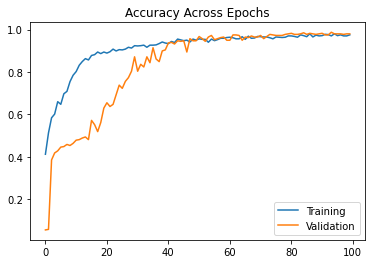

In [906]:
plt.plot(history.history['accuracy'],label='Training')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.title('Accuracy Across Epochs')
plt.legend()
plt.show()

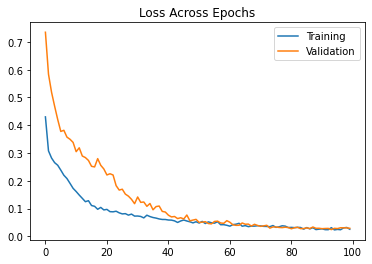

In [907]:
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.title('Loss Across Epochs')
plt.legend()
plt.show()

In [898]:
preds=Final_Model.predict(X_test)
print("Confusion Matrix:\n",confusion_matrix(y_test,preds))

array([[18,  3,  2,  0,  0,  0],
       [ 4, 20,  1,  0,  0,  0],
       [ 2,  1,  3,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0],
       [ 0,  1,  0,  0,  2,  0],
       [ 0,  1,  0,  0,  0,  9]], dtype=int64)

In [918]:
print("Test Accuracy:",accuracy_score(preds,y_test))

Test Accuracy: 0.7887323943661971


Logistic Regression: 0.6901
SVM: 0.7746
KNN: 0.7465
Decision Tree: 0.7606
Random Forest: 0.8592
ANN: 0.7887


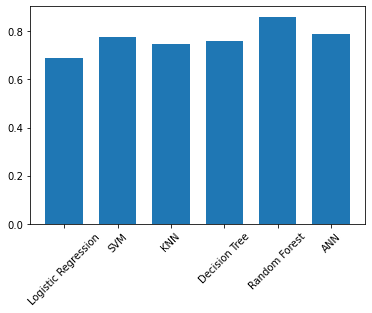

In [917]:
all_models = list(models.keys())
all_models.append('ANN')
all_results = list(results)
all_results.append(accuracy_score(preds,y_test))
print("Overall test accuracy")
for i,m in enumerate(all_models):
    print(f"{m}: {round(all_results[i],4)}")
plt.bar(all_models,all_results, align='center',width=0.7)
plt.xticks(rotation=45)
plt.show()